In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor 
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
import scipy.stats as stats

In [308]:
#Функция валидация
def cross_validation(train, features, target):
    msle_list = []
    mse_list = []

    kf = KFold(n_splits=5, shuffle = True)
    for i, (train_index, val_index) in enumerate(kf.split(train)):
        train_part = train.loc[train_index, : ]
        val_part = train.loc[val_index,:  ]
#         model = SGDRegressor()
        model = ElasticNet()
        model.fit( X=train_part[features], y = train_part[target] )
        val_prediction = model.predict(val_part[features]).clip(0, 1000000000)
#if 0 нужно проверить почему

        mse = mean_squared_error(val_prediction,  val_part[target]  )
        msle = mean_squared_log_error(val_prediction,  val_part[target]  )


        msle_list.append(msle)
        mse_list.append(mse)
        print( f'Fold {i}: msle {msle} , mse {mse}')
        
    print( f'MSLE average = {np.mean(msle_list)} , std ={np.std(msle_list)}  ')

№1. Построим первые три модели. Используем только признаки ['metro_km_walk', 'kremlin_km', 'full_sq'] и их нулевые или Nan значения:

1.1. Заполним 0
1.2. Заполним std 
1.3. Заполним mean

В качестве модели используем model = SGDRegressor()


In [529]:
train = pd.read_csv('../Data/data/raw/train.csv')
test  = pd.read_csv('../Data/data/raw/test.csv') 
features = ['metro_km_walk', 'kremlin_km', 'full_sq']
target = 'price_doc'

In [530]:
#1.1. Заполним 0
model = ElasticNet()
train[features] = train[features].fillna(0)
test[features] = test[features].fillna(0)
cross_validation(train, features, target)

Fold 0: msle 0.3077631813340056 , mse 20731650806899.39
Fold 1: msle 0.32231679749467856 , mse 16941464666572.469
Fold 2: msle 0.3211821436822271 , mse 15877505681699.896
Fold 3: msle 0.3561612841399982 , mse 15700653857903.477
Fold 4: msle 0.8651165059478294 , mse 75920547893789.58
MSLE average = 0.43450798251974776 , std =0.2158961592845461  


In [516]:
#1.2. Заполним std  
def std_intersection(data, features):
    std_array = {}
    data[features] = data[features].fillna(0)
    for feature in features: 
        std_array[feature] = data[feature].std()
    print(std_array)
    for feature in features: 
         data.loc[data[feature] == 0] = std_array[feature]


model = ElasticNet()            
std_intersection(train, features)
std_intersection(test, features)
cross_validation(train, features, target)

{'metro_km_walk': 5.77379174649847, 'kremlin_km': 8.441964402701597, 'full_sq': 38.031487324105015}
{'metro_km_walk': 6.368312129238434, 'kremlin_km': 8.694791587186124, 'full_sq': 20.10432001408528}
Fold 0: msle 1.0959062335020249 , mse 77947548173221.73
Fold 1: msle 0.5269719641105048 , mse 17682985570069.688
Fold 2: msle 0.5160613064845999 , mse 16388269583018.14
Fold 3: msle 0.4140664502779597 , mse 15336142840519.361
Fold 4: msle 0.5218624523946949 , mse 18814485721296.727
MSLE average = 0.6149736813539569 , std =0.24407273354992975  


In [525]:
#1.3 Заполним mean.
features = ['metro_km_walk', 'kremlin_km', 'full_sq']
target = 'price_doc'
model = ElasticNet()            

mean_metro_km_walk = train['metro_km_walk'].mean()
mean_kremlin_km = train['kremlin_km'].mean()
mean_full_sq = train['full_sq'].mean()

train[features] = train[features].fillna(0)
test[features] = test[features].fillna(0)

train.loc[train['metro_km_walk'] ==0] = mean_metro_km_walk
train.loc[train['kremlin_km'] ==0] = mean_kremlin_km
train.loc[train['full_sq'] ==0] = mean_full_sq

test.loc[test['metro_km_walk'] ==0] = mean_metro_km_walk
test.loc[test['kremlin_km'] ==0] = mean_kremlin_km
test.loc[test['full_sq'] ==0] = mean_full_sq
cross_validation(train, features, target)

Fold 0: msle 0.539185250033138 , mse 14595609621913.334
Fold 1: msle 0.520461034920551 , mse 16095083953305.809
Fold 2: msle 0.4598885325861669 , mse 17220483597522.043
Fold 3: msle 1.134795420726051 , mse 82372450373109.86
Fold 4: msle 0.6639585859763103 , mse 20444740758548.67
MSLE average = 0.6636577648484435 , std =0.2447412477301053  


In [531]:
model = ElasticNet()
model.fit(X=train[features], y = train[target])

ElasticNet()

In [532]:
name = "1.nulls"
sample_submission = pd.read_csv('../Data/data/raw/sample_submission.csv')  
sample_submission['price_doc']= model.predict(test[features]).clip(0.001, 100000000000)
sample_submission.to_csv(name + '.csv', index = False) 

In [533]:
!kaggle competitions submit -c sberbank-russian-housing-market -f 1.nulls.csv -m "Message"

100%|████████████████████████████████████████| 180k/180k [00:03<00:00, 50.1kB/s]
Successfully submitted to Sberbank Russian Housing Market

#2 НОРМИРОВАНИЕ Во второй модели нормируйте признаки из первой модели (std=1, mean = 0).

In [547]:
train = pd.read_csv('../Data/data/raw/train.csv')
test  = pd.read_csv('../Data/data/raw/test.csv') 
features = ['metro_km_walk', 'kremlin_km', 'full_sq']
target = 'price_doc'

In [548]:
from sklearn.linear_model import ElasticNet

def std_intersection(data, features):
    std_array = {}
    data[features] = data[features].fillna(0)
    for feature in features: 
        std_array[feature] = data[feature].std()
    print(std_array)
    for feature in features: 
         data.loc[data[feature] == 0] = std_array[feature]
            
def normalisation(data, features):
    for feature in features: 
        data[feature] = data[feature].clip(0.0001,100000000000000)
        data[feature] = stats.boxcox(data[feature])[0]            

In [549]:
# std_intersection(train, features)
# std_intersection(test, features)
train[features] = train[features].fillna(0)
test[features] = test[features].fillna(0)

normalisation(train, features)
normalisation(test, features)

cross_validation(train, features, target)

model = ElasticNet()
model.fit( X=train[features], y = train[target] )

Fold 0: msle 0.33413333120304367 , mse 15870131453845.615
Fold 1: msle 0.4381140571493678 , mse 15536621479886.77
Fold 2: msle 0.561408260089751 , mse 16936061630106.865
Fold 3: msle 0.6046231227571526 , mse 14207924835856.33
Fold 4: msle 0.6128240443625307 , mse 16246505193974.27
MSLE average = 0.5102205631123692 , std =0.10794958026566692  


ElasticNet()

In [550]:
name = "2.normalisation_one_more"
sample_submission = pd.read_csv('../Data/data/raw/sample_submission.csv')  
sample_submission['price_doc']= model.predict(test[features]).clip(0.001, 100000000000)
sample_submission.to_csv(name + '.csv', index = False) 

In [551]:
!kaggle competitions submit -c sberbank-russian-housing-market -f 2.normalisation_one_more.csv -m "Message"

100%|████████████████████████████████████████| 180k/180k [00:03<00:00, 59.4kB/s]
Successfully submitted to Sberbank Russian Housing Market

#3. Во второй модели добавлены преобразованные различным образом категориальне признаки ['product_type' , 'sub_area' ] и т.д. 

Сделать замену на train[target]


In [209]:
sample_submission['price_doc'][sample_submission['price_doc']<0]

Series([], Name: price_doc, dtype: float64)

In [552]:
train = pd.read_csv('../Data/data/raw/train.csv')
test  = pd.read_csv('../Data/data/raw/test.csv') 
features = ['metro_km_walk', 'kremlin_km', 'full_sq']
target = 'price_doc'

In [553]:
# std_intersection(train, features)
# std_intersection(test, features)
train[features] = train[features].fillna(0)
test[features] = test[features].fillna(0)

# normalisation(train, features)
# normalisation(test, features)

In [554]:
def target_encoding(train, test,  features_encoding, target):
    for feature in features_encoding:
        feature_encoding = train.groupby([feature])[target].mean()
        train[feature] = train[feature].replace(feature_encoding) 
        test[feature] = test[feature].replace(feature_encoding)

        train[feature] = train[feature].fillna(train[feature].std())
        test[feature] = test[feature].fillna(test[feature].std())


    
#     std_intersection(train, features_encoding)
#     std_intersection(test, features_encoding)

In [555]:
features_encoding = ['sub_area', 'product_type']        
target_encoding(train, test, features_encoding, target)


# normalisation(train, features_encoding)
# normalisation(test, features_encoding)

# train['sub_area'] = train['sub_area'].replace( train.groupby(['sub_area'])[target].mean()) 
# train['sub_area'] = train['sub_area'].replace( train.groupby(['sub_area'])[target].mean()) 

In [557]:
cross_validation(train, features+features_encoding, target)

Fold 0: msle 0.6795001091157847 , mse 62214750988033.5
Fold 1: msle 0.29869426809415367 , mse 16065041496287.045
Fold 2: msle 0.3186377023422834 , mse 12982562836521.541
Fold 3: msle 0.2915932749828331 , mse 13865877216696.793
Fold 4: msle 0.28227271067062876 , mse 15412453883692.266
MSLE average = 0.3741396130411368 , std =0.1531475892114114  


In [558]:
model = ElasticNet()
model.fit( X=train[features+features_encoding], y = train[target] )

ElasticNet()

In [559]:
name = "3.features_encoding"
sample_submission = pd.read_csv('../Data/data/raw/sample_submission.csv')  
sample_submission['price_doc']= model.predict(test[features+features_encoding]).clip(0.001, 100000000000)
sample_submission.to_csv(name + '.csv', index = False) 

In [560]:
!kaggle competitions submit -c sberbank-russian-housing-market -f '3.features_encoding.csv' -m "Message"

100%|████████████████████████████████████████| 180k/180k [00:04<00:00, 39.9kB/s]
Successfully submitted to Sberbank Russian Housing Market

In [652]:
#4. Добавляем признаки временные и здесь же пробуем #5 новый таргет
train = pd.read_csv('../Data/data/raw/train.csv')
test  = pd.read_csv('../Data/data/raw/test.csv') 
# features = ['month', 'day_week', 'day_month_datetime', 'year', 'seconds']
features = ['metro_km_walk', 'kremlin_km', 'full_sq', 'month', 'year']
# target = 'price_doc'
target = 'price_m2'

In [653]:
#Data time features
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] =  pd.to_datetime(test['timestamp']) 

In [654]:
def get_date_time_features(timestamp_series: pd.Series) -> pd.DataFrame:
    output= pd.DataFrame()
    output['timestamp']= timestamp_series
    output['month'] = timestamp_series.dt.month.astype(np.int8)
    output['day_week'] = timestamp_series.dt.dayofweek.astype(np.int8)
    output['day_month_datetime'] =timestamp_series.dt.day.astype(np.int8)
    output['year'] = timestamp_series.dt.year.astype(np.int16)
    output['seconds'] = timestamp_series.astype(int)/1_000_000_000_000_000 
    return output 
train = pd.concat( [train, get_date_time_features(train['timestamp'])] , axis=1 ) 
test = pd.concat( [test, get_date_time_features(test['timestamp'])] , axis=1 ) 

/var/folders/vm/jy5f0l6n6pl3qyyzwbsfth7w0000gn/T/ipykernel_2068/291749181.py:8: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  output['seconds'] = timestamp_series.astype(int)/1_000_000_000_000_000


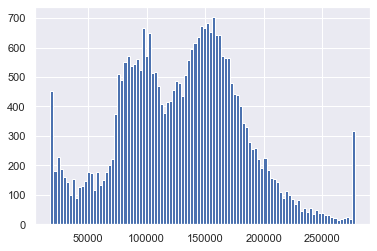

In [655]:
#5. new target
lol = "full_sq"
train["full_sq"] = train["full_sq"].fillna(train["full_sq"].std())
train.loc[train["full_sq"]==0] = train["full_sq"].std()
test["full_sq"] = test["full_sq"].fillna(test["full_sq"].std())
test.loc[test["full_sq"]==0] = test["full_sq"].std()


#std_intersection(train, lol)

train['price_m2'] =   train['price_doc']/ (train['full_sq']+1)
train['price_m2'] = train['price_m2'].clip(train['price_m2'].quantile(0.01), train['price_m2'].quantile(0.99))
plt.hist(train['price_m2'] , bins =100  )
plt.show() 

In [656]:
train[features] = train[features].fillna(0)
test[features] = test[features].fillna(0)

In [658]:
# features_encoding = []        
features_encoding = ['sub_area', 'product_type']        
target_encoding(train, test, features_encoding, target)

In [659]:
cross_validation(train, features+features_encoding, target)

Fold 0: msle 0.218386248468626 , mse 1740095924.6018493
Fold 1: msle 0.22655124712276664 , mse 1795358912.3790905
Fold 2: msle 0.2608939663804338 , mse 1774753534.219725
Fold 3: msle 0.24365303351199674 , mse 1751709402.107231
Fold 4: msle 0.22456276903321787 , mse 1775331644.2839253
MSLE average = 0.2348094529034082 , std =0.015501773435780965  


In [660]:
model = ElasticNet()
model.fit( X=train[features+features_encoding], y = train[target] )

ElasticNet()

In [661]:
name = "5.data"
sample_submission = pd.read_csv('../Data/data/raw/sample_submission.csv')  
test_prediction = model.predict(test[features+features_encoding])


In [662]:
test_prediction_transformation = test_prediction*(test['full_sq']+1)

0       5.001244e+06
1       8.682667e+06
2       5.552206e+06
3       6.036208e+06
4       4.543068e+06
            ...     
7657    8.857655e+06
7658    5.046466e+06
7659    4.853382e+06
7660    4.976957e+06
7661    9.562191e+06
Name: full_sq, Length: 7662, dtype: float64

In [663]:
#4
# sample_submission['price_doc']= test_prediction.clip(0.001, 100000000000)
#5
sample_submission['price_doc']= test_prediction_transformation.clip(0.001, 100000000000) 
sample_submission.to_csv(name + '.csv', index = False) 

In [664]:
!kaggle competitions submit -c sberbank-russian-housing-market -f '5.data.csv' -m "Message"

100%|████████████████████████████████████████| 180k/180k [00:04<00:00, 43.1kB/s]
Successfully submitted to Sberbank Russian Housing Market